In [1]:
from requests import get

from bs4 import BeautifulSoup
from IPython.display import clear_output
import pandas as pd

from collections import Counter
import numpy as np

import lightgbm as lg
from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score

import matplotlib.pyplot as plt

In [493]:
import pickle as pk

In [8]:
urls = ['https://www.imdb.com/title/tt1751105/episodes?season=' + str(i) for i in range(1,10)]

In [9]:
rating = []
votes = []
links = []

for s,url in enumerate(urls):
    resp = get(url)
    html_soup = BeautifulSoup(resp.text, 'html.parser')
    episode_containers_even = html_soup.find_all('div', class_ = 'list_item even')
    episode_containers_odd = html_soup.find_all('div', class_ = 'list_item odd')
    num_ = len(episode_containers_even) + len(episode_containers_odd)
    
    rating_, votes_, links_ = [0]*num_, [0]*num_, ['']*num_
    
    for i,ep in enumerate(episode_containers_odd):
        rating_[2*i] = float(ep.find('span', class_="ipl-rating-star__rating").text)
        votes_[2*i] = int(ep.find('span', class_="ipl-rating-star__total-votes").text[1:-1])
        links_[2*i] = ep.strong.a.attrs['href']
    for i,ep in enumerate(episode_containers_even):
        rating_[2*i+1] = float(ep.find('span', class_="ipl-rating-star__rating").text)
        votes_[2*i+1] = int(ep.find('span', class_="ipl-rating-star__total-votes").text[1:-1])
        links_[2*i+1] = ep.strong.a.attrs['href']
    rating += [rating_]
    votes += [votes_]
    links += [links_]

links_ = [['https://www.imdb.com' + link_ +'ratings?ref_=tt_ov_rt' for link_ in _] for _ in links]

In [10]:
parsed_tables = []
for season in range(9):
    parsed_tables_season = []
    for num in range(len(links_[season])):
        print(links_[season][num])
        resp = get(links_[season][num])
        html_soup = BeautifulSoup(resp.text, 'html.parser')
        tables = html_soup('div', class_='title-ratings-sub-page')[0]('table')

        parsed_tables_ = []
        table_ = []

        #tables[0]
        for tr in tables[0]('tr')[1:]:
            table_ += [int(tr('div', class_='leftAligned')[0].text)]

        parsed_tables_ += [table_]

        #tables[1]
        table_ = {}
        for tr, y in zip(tables[1]('tr')[1:], ['All', 'Males', 'Females']):
            table_[y] = {}
            for td, x in zip(tr('td')[1:], ['All Ages', '<18', '18-29', '30-44', '45+']):
                print(y,x)
                table_[y][x] = None if td.a is None else int(td.a.text)
        parsed_tables_ += [table_]

        #tables[2]
        table_ = {}
        for tr in tables[1]('tr')[1:]:
            for td, x in zip(tr('td')[1:], ['Top 1000 Voters', 'US Users', 'Non-US Users']):
                table_[x] = None if td.a is None else int(td.a.text)
        parsed_tables_ += [table_]
        parsed_tables_season += [parsed_tables_]
        clear_output()
    parsed_tables += [parsed_tables_season]

In [11]:
data = pd.read_json("my-little-pony-friendship-is-magic-episode-data/episodes.json", orient='index')

In [12]:
data['rating'] = None
data['votes'] = None
for i in ['All', 'Males', 'Females']:
    for j in ['All Ages', '<18', '18-29', '30-44', '45+']:
        data[i+'_'+j] = None

for _ in ['Top 1000 Voters', 'US Users', 'Non-US Users']:
    data[_] = None
    
for _ in range(1,11):
    data[str(_)+'_rate'] = None

In [13]:
for s in range(len(rating)):
    for i in range(len(rating[s])):
        m = (data.loc[:,'season'] == s+1) & (data.loc[:,'number_in_season'] == i+1)
        data.loc[m,'rating'] = rating[s][i]
        data.loc[m,'votes'] = votes[s][i]
        
        for _ in range(10):
            data.loc[m, str(10-_)+'_rate'] = parsed_tables[s][i][0][_]
            
        for x in ['All', 'Males', 'Females']:
            for y in ['All Ages', '<18', '18-29', '30-44', '45+']:
                data.loc[m, x+'_'+y] = parsed_tables[s][i][1][x][y]
            
        for _ in ['Top 1000 Voters', 'US Users', 'Non-US Users']:
            data.loc[m,_] = parsed_tables[s][i][2][_]

In [14]:
data.loc[data.loc[:,'season']==9,'transcript']

197    [{'character': 'Fluttershy', 'line': 'Oh, good...
198    [{'character': 'Princess Celestia', 'line': 'I...
199    [{'character': 'Rainbow Dash', 'line': 'Congra...
200    [{'character': 'Spike', 'line': 'Twilight! Loo...
201    [{'character': 'Spike', 'line': 'Whoa!'}, {'ch...
202    [{'character': 'Announcer', 'line': 'Highlight...
203    [{'character': 'Silverstream', 'line': 'See?! ...
204    [{'character': 'Cozy Glow', 'line': 'I don't w...
205    [{'character': 'Smolder', 'line': 'Uh, Headmar...
206    [{'character': 'Applejack', 'line': 'I know we...
207    [{'character': 'Trixie', 'line': 'I know how h...
208    [{'character': 'Skeedaddle', 'line': 'Cutie Ma...
209    [{'character': 'Twilight Sparkle', 'line': 'Re...
210    [{'character': 'Rainbow Dash', 'line': 'I thou...
211    [{'character': 'Twilight Sparkle', 'line': 'I ...
212    [{'character': 'Spike', 'line': 'Okay, Spike. ...
213    [{'character': 'Cozy Glow', 'line': 'Where are...
214    [{'character': 'Flutters

In [15]:
len(data.loc[:, 'transcript'])

221

In [16]:
np.isnan

<ufunc 'isnan'>

In [17]:
res = {}

for transcript in data.loc[:, 'transcript']:
    if type(transcript) is float:
        continue
    for line in transcript:
        if line['character'] not in res:
            res[line['character']] = []
            

        #res[line['character']]['lines'] = res[line['character']].get('lines',[])\
        #                                        + [line['line'].split(' ')]
        #res[line['character']] = res.get(line['character'], {}).get('proportions') + [line['line'].split(' ')]
        

In [19]:
word_counts = pd.DataFrame(0,index = np.arange(data.shape[0]), columns=[character for character in res])

In [20]:
for i,transcript in enumerate(data.loc[:, 'transcript']):
    if type(transcript) is float:
        continue
    for line in transcript:
        word_counts.loc[i,line['character']] += len(line['line'].split(' '))
    
    

In [21]:
word_counts_normed = word_counts.div(word_counts.sum(axis=1), axis=0)

In [22]:
word_counts_normed.head()

,Narrator,Narrator and Twilight Sparkle,Twilight Sparkle,Twinkleshine,Spike,Applejack,Granny Smith,Apple Bloom,Rainbow Dash,Rarity,...,Townspony 4,Star Spur,Senior Deputy,Trouble Shoes,Young Trouble Shoes,Judge,Tree Hugger,Storekeeper,Young Gilda,Young Gilda and Young Rainbow Dash
0,0.079839,0.00121,0.372581,0.014113,0.153629,0.044355,0.004032,0.002419,0.053226,0.054839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.00000,0.336418,0.000000,0.063146,0.088732,0.000000,0.000000,0.054981,0.069134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.00000,0.008567,0.000000,0.000000,0.000000,0.000000,0.008567,0.003808,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.00000,0.098785,0.000000,0.547808,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.00000,0.240529,0.000000,0.007759,0.082611,0.000000,0.000000,0.047010,0.030580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
_ = word_counts_normed.mean(axis=0)


In [24]:
char_freq = pd.DataFrame(_)

In [25]:
char_freq.sort_values(0, ascending=False).head()

,0
Twilight Sparkle,0.142187
Rarity,0.082765
Rainbow Dash,0.081366
Pinkie Pie,0.077768
Applejack,0.074501


In [26]:
X, y = np.array(word_counts_normed), np.array(data.loc[:, 'rating'])
#X, y = np.array(word_counts), np.array(data.loc[:, 'rating'])
m = y == None

X = X[np.logical_not(m), :]
y = y[np.logical_not(m)].astype('float')

m = np.isnan(y)

X = X[np.logical_not(m), :]
y = y[np.logical_not(m)]


### Predict rating through words counter

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.1)

In [95]:
model = lg.LGBMRegressor('rf', learning_rate=0.01, n_estimators=2000,\
                         colsample_bytree=1, num_leaves=31, subsample=0.4, subsample_freq=1,\
                         reg_alpha=0, min_child_samples=1, min_child_weight=1e-5, importance_type='split')

In [74]:
model = lg.LGBMRegressor('goss', learning_rate=0.0008, n_estimators=1500,\
                         colsample_bytree=1, num_leaves=4, subsample=0.4,\
                         reg_alpha=1e-1, min_child_samples=3, min_child_weight=1e-6, importance_type='gain')

In [96]:
y_train, y_test = y_train.astype('float'), y_test.astype('float')

In [97]:
model.fit(X_train, y_train) 

LGBMRegressor(boosting_type='rf', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=1, min_child_weight=1e-05, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0, reg_lambda=0.0, silent=True,
              subsample=0.4, subsample_for_bin=200000, subsample_freq=1)

In [98]:
y_pred = model.predict(X_test)

print(((y_test - y_train.mean())**2).mean())

((y_pred - y_test)**2).mean()

0.4396967120455269


0.29871227969849506

In [99]:
explained_variance_score(y_test, y_pred)

0.33103985560076876

In [100]:
importances = pd.DataFrame(model.feature_importances_, index=word_counts_normed.columns).sort_values(0,ascending=False, axis=0)

### Importances

In [176]:
importances.head()

,0
Twilight Sparkle,6672
Applejack,6039
Spike,5529
Rainbow Dash,4120
Fluttershy,4027


In [177]:
villains = ['Starlight Glimmer', 'Storm King', 'The Dazzlings',\
 'Queen Chrysalis', 'King Sombra', 'Tirek', 'Discord', 'Tantabus',\
 'Pony of Shadows', 'Nightmare Moon']

In [178]:
villains_importances = importances.loc[villains]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [179]:
mask = np.logical_not(np.isnan(villains_importances.loc[:, 0]))
villains_importances = villains_importances.loc[mask,:]

In [180]:
top = importances.head(15)

### top 15 importances

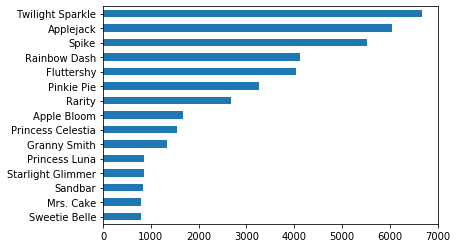

In [181]:
top.loc[::-1].plot.barh(legend=False)

### villain importances

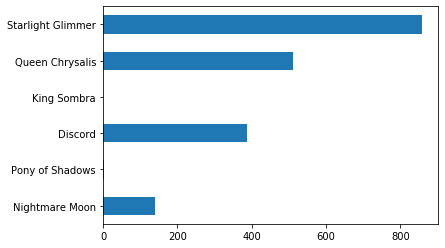

In [183]:
villains_importances.loc[::-1].plot.barh(legend=False)

In [569]:
with open('Villains', 'wb') as fp:
    pk.dump(villains_importances, fp)

## LDA on characters lines

In [474]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

In [475]:
n_components = 5
topic_model = LDA(n_components, n_jobs=-1, max_iter=500, learning_decay=0.5, max_doc_update_iter=500)

In [476]:
characters = {i:[] for i in list(top.index) + list(villains_importances.index)}

every document is just one line

In [477]:
for transcript in data.loc[:, 'transcript']:
    if type(transcript) is float:
        continue
    for line in transcript:
        if line['character'] not in characters:
            continue
        characters[line['character']] += [line['line']]

In [478]:
vectorizer = CountVectorizer(stop_words='english', token_pattern='[a-zA-Z]{3,15}', ngram_range=(1,2))

In [479]:
Components = {}
_ = {}
for character in characters.keys():
    _[character] = vectorizer.fit_transform(characters[character])
    topic_model.fit(_[character])
    components = topic_model.components_.argsort()[:, -10:]
    vocab = vectorizer.get_feature_names()
    indices = np.array(components).ravel()
    normed_components = topic_model.components_/topic_model.components_.sum(axis=-1)[:, np.newaxis]
    normed_components = normed_components[np.arange(n_components)[:, np.newaxis],components]
    Components[character] = [ [[vocab[i], popularity] for i, popularity in zip(component, n_comp)]\
                             for component, n_comp in zip(components, normed_components)]

In [486]:
len(Components['Discord'])

5

In [490]:
kek = np.array(Components['Twilight Sparkle'][0])

In [491]:
kek[:,0]

array(['celestia', 'don', 'going', 'pinkie', 'know', 'good', 'just',
       'spike', 'princess', 'like'], dtype='<U21')

<BarContainer object of 10 artists>

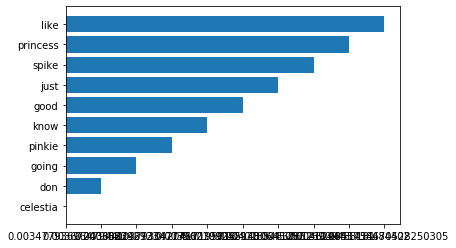

In [492]:
plt.barh(kek[:,0], kek[:,1])

with open('Components_per_line', 'wb') as fp:
    pk.dump(Components, fp)

every document is episode

In [527]:
characters = {i:[] for i in list(top.index) + list(villains_importances.index)}

In [528]:
[ ' ' + np.array(data.loc[:, 'transcript'])[0][0]['line']]

[" Once upon a time, in the magical land of Equestria, there were two regal sisters who ruled together and created harmony for all the land. To do this, the eldest used her unicorn powers to raise the sun at dawn; the younger brought out the moon to begin the night. Thus, the two sisters maintained balance for their kingdom and their subjects, all the different types of ponies. But as time went on, the younger sister became resentful. The ponies relished and played in the day her elder sister brought forth, but shunned and slept through her beautiful night. One fateful day, the younger unicorn refused to lower the moon to make way for the dawn. The elder sister tried to reason with her, but the bitterness in the young one's heart had transformed her into a wicked mare of darkness: Nightmare Moon."]

In [536]:
for transcript in data.loc[:, 'transcript']:
    if type(transcript) is float:
        continue
    res = {ch:"" for ch in characters}
    for line in transcript:
        if line['character'] not in characters:
            continue
        res[line['character']] += ' ' + line['line']
    for ch in res:
        characters[ch] += [res[ch]]

In [538]:
Components = {}
_ = {}
for character in characters.keys():
    _[character] = vectorizer.fit_transform(characters[character])
    topic_model.fit(_[character])
    components = topic_model.components_.argsort()[:, -10:]
    vocab = vectorizer.get_feature_names()
    indices = np.array(components).ravel()
    normed_components = topic_model.components_/topic_model.components_.sum(axis=-1)[:, np.newaxis]
    normed_components = normed_components[np.arange(n_components)[:, np.newaxis],components]
    Components[character] = [ [[vocab[i], popularity] for i, popularity in zip(component, n_comp)]\
                             for component, n_comp in zip(components, normed_components)]

In [539]:
kek = np.array(Components['Twilight Sparkle'][0])

In [557]:
kek[:,1].astype(float)[-5:]

array([0.00308662, 0.00380131, 0.0038728 , 0.00401546, 0.00451572])

<BarContainer object of 10 artists>

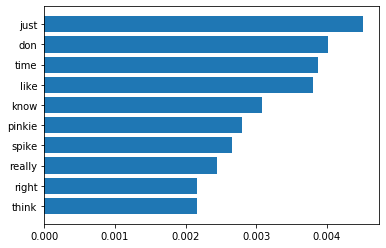

In [559]:
plt.barh(kek[:,0], kek[:,1].astype(float))

In [560]:
with open('Components_per_episode', 'wb') as fp:
    pk.dump(Components, fp)

## Ratings and Number of marks Through time (take a look on the end and start of seasons)

## Genders and ages of spectators through time

## Ratings to Number of marks dependency(?)

## Activity of character to Writer dependency

## Writer/Director rating dependecy


## Activity of character to time

with open('Top_characters', 'wb') as fp:
    pk.dump(top, fp)

with open('Word_counts', 'wb') as fp:
    pk.dump(word_counts,fp)

## Number of words/Complexity(number of characters -- plotlines) to author/time